In [1]:
using BenchmarkTools
using Distributions
using Optim
using Roots
using StatsBase
using StatsPlots
default(fmt=:png, titlefontsize=8, plot_titlefontsize=10, tickfontsize=6)
safediv(x, y) = x == 0 ? x : y == Inf ? zero(y) : x/y

safediv (generic function with 1 method)

In [2]:
riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d; u=0)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-u) + safediv(q̂*(1-q̂), n-u))
end

function pvalue_rd_wald(a, b, c, d; Δ=0, u=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d; u)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end

function confint_rd_wald(a, b, c, d; α=0.05, u=0)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d; u)
    [RDhat - z*SEhat_riskdiffhat, RDhat + z*SEhat_riskdiffhat]
end

confint_rd_wald (generic function with 1 method)

In [3]:
riskdiffhat_zou_donner(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat_zou_donner(a, b, c, d; u=1)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-u) + safediv(q̂*(1-q̂), n-u))
end

function pvalue_rd_zou_donner(a, b, c, d; Δ=0, u=1)
    ((a==0 && d==0) || (b==0 && c==0)) && return 1.0
    RDhat = riskdiffhat_zou_donner(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat_zou_donner(a, b, c, d; u)
    Z = safediv((1 - RDhat^2)*abs(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
    2ccdf(Normal(), abs(Z))
end

function confint_rd_zou_donner(a, b, c, d; α=0.05, u=1)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat_zou_donner(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat_zou_donner(a, b, c, d; u)
    m = atanh(RDhat)
    d = safediv(z*SEhat_riskdiffhat, 1 - RDhat^2)
    [tanh(m-d), tanh(m+d)]
end

confint_rd_zou_donner (generic function with 1 method)

In [4]:
"""Bayes版P値函数達を作る函数"""
function make_pvalue_rd_bayes(a, b, c, d; M=10^6, conjprior=(1//3, 1//3))
    α, β = conjprior
    p = rand(Beta(α+a, β+b), M)
    q = rand(Beta(α+c, β+d), M)
    Δ = @. p - q
    ecdf_RD = ecdf(Δ)
    pvalue_rd_bayes(Δ) = min(1, 2ecdf_RD(Δ), 2(1-ecdf_RD(Δ)))
    pvalue_rd_bayes
end

make_pvalue_rd_bayes

In [5]:
_f(q, Δ, a, b, c, d) = a/(q+Δ) - b/(1-q-Δ) + c/q - d/(1-q)

function qtilde(a, b, c, d; Δ=0.0, alg=Order2())
    x0 = (max(0, -Δ) + min(1, 1-Δ))/2
    find_zero(q -> _f(q, Δ, a, b, c, d), x0, alg)
end

qtilde (generic function with 1 method)

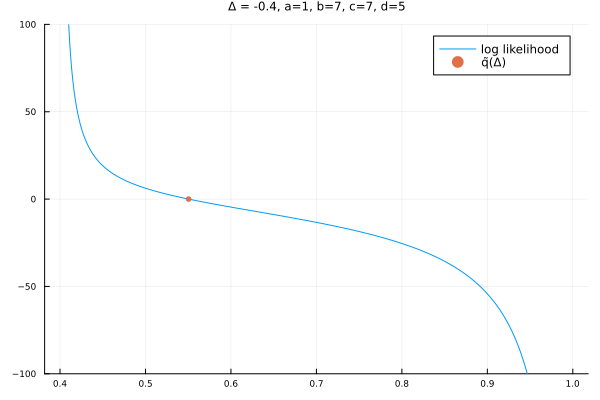

In [6]:
m, n = 8, 12
q, Δ = 0.5, -0.4
a = rand(Binomial(m, q+Δ))
b = m - a
c = rand(Binomial(n, q))
d = n - c
q̃ = qtilde(a, b, c, d; Δ, alg=Order2())
qs = range(max(0, -Δ)+eps(), min(1, 1-Δ)-eps(), 1000)
plot(qs, q -> _f(q, Δ, a, b, c, d); ylim=(-1e2, 1e2), label="log likelihood")
scatter!([q̃], [0.0]; ms=3, msw=0, label="q̃(Δ)")
title!("Δ = $Δ, a=$a, b=$b, c=$c, d=$d")

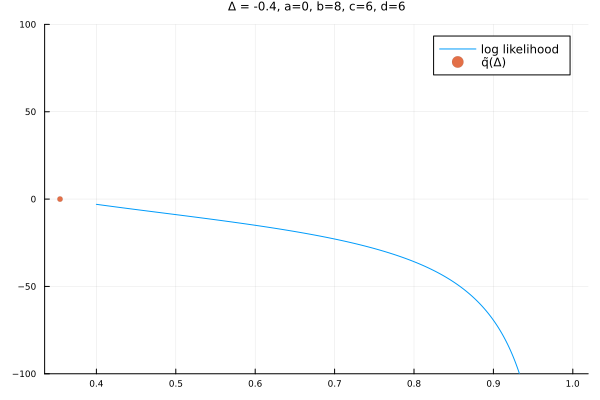

In [7]:
m, n = 8, 12
q, Δ = 0.5, -0.4
(a, b, c, d) = (0, 8, 6, 6)
q̃ = qtilde(a, b, c, d; Δ, alg=Order2())
qs = range(max(0, -Δ)+eps(), min(1, 1-Δ)-eps(), 1000)
plot(qs, q -> _f(q, Δ, a, b, c, d); ylim=(-1e2, 1e2), label="log likelihood")
scatter!([q̃], [0.0]; ms=3, msw=0, label="q̃(Δ)")
title!("Δ = $Δ, a=$a, b=$b, c=$c, d=$d")

In [8]:
function chisq_score(a, b, c, d; Δ=0.0, alg=Order2())
    m, n = a+b, c+d
    q̃ = qtilde(a, b, c, d; Δ, alg)
    #q̃ = clamp(q̃, max(0, -Δ), min(1, 1-Δ))
    R = (q̃+Δ)*(1-q̃-Δ)/m
    S = q̃*(1-q̃)/n
    A = safediv(a, q̃+Δ) - safediv(b, 1-q̃-Δ)
    B = safediv(c, q̃) - safediv(d, 1-q̃)
    S*(A+B)^2 + 2S*A*(A+B) + (R+S)*A^2
end

function chisq_loglikrat(a, b, c, d; Δ=0.0, alg=Order2())
    m, n = a+b, c+d
    q̃ = qtilde(a, b, c, d; Δ, alg)
    q̃ = clamp(q̃, max(0, -Δ), min(1, 1-Δ))
    ll1 = loglikelihood(Binomial(m, a/m), a) + loglikelihood(Binomial(n, c/n), c)
    ll0 = loglikelihood(Binomial(m, q̃+Δ), a) + loglikelihood(Binomial(n, q̃), c)
    2(ll1 - ll0)
end

chisq_loglikrat (generic function with 1 method)

  0.146348 seconds (404.48 k allocations: 21.337 MiB, 76.62% compilation time)
  0.193843 seconds (406.88 k allocations: 20.899 MiB, 61.48% compilation time)


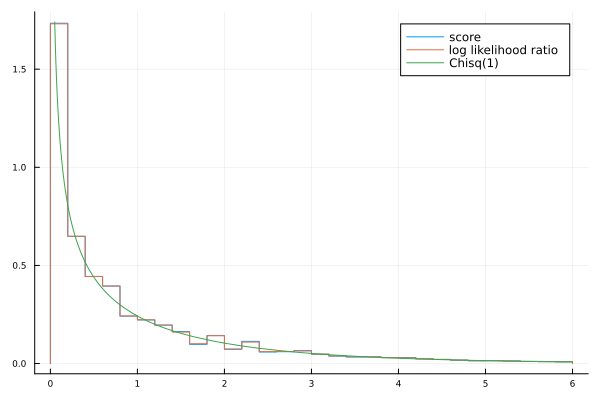

In [9]:
m, n = 1000, 1000
q, Δ = 0.5, 0.2
L = 10^5
a = rand(Binomial(m, q+Δ), L)
b = m .- a
c = rand(Binomial(n, q), L)
d = n .- c
@time X = chisq_score.(a, b, c, d; Δ)
@time Y = chisq_loglikrat.(a, b, c, d; Δ)
stephist(X; norm=true, bin=0:0.2:6, label="score")
stephist!(Y; norm=true, bin=0:0.2:6, label="log likelihood ratio")
plot!(Chisq(1), 0.05, 6; label="Chisq(1)")

In [10]:
function pvalue_rd_score(a, b, c, d; Δ=0.0, alg=Order2())
    χ² = chisq_score(a, b, c, d; Δ, alg)
    ccdf(Chisq(1), χ²)
end

function pvalue_rd_loglikrat(a, b, c, d; Δ=0.0, alg=Order2())
    χ² = chisq_loglikrat(a, b, c, d; Δ, alg)
    ccdf(Chisq(1), χ²)
end

pvalue_rd_loglikrat (generic function with 1 method)

(a, b, c, d) = (0, 8, 7, 5)
q̃ = qtilde(a, b, c, d; Δ, alg = Order2()) = 0.4181379562757746
q̃ + Δ = 0.01813795627577458
Δ̂ = a / m - c / n = -0.5833333333333334


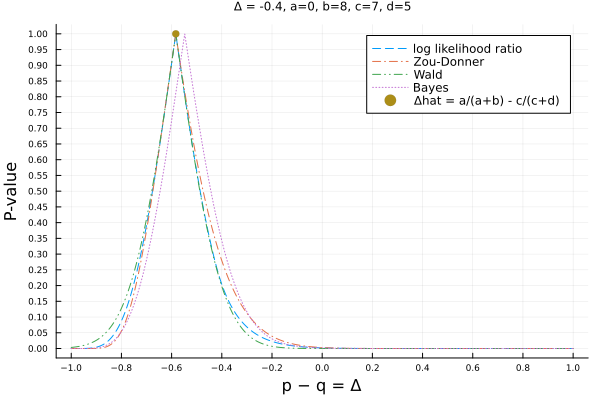

In [11]:
m, n = 8, 12
q, Δ = 0.5, -0.4
a = rand(Binomial(m, q+Δ))
b = m - a
c = rand(Binomial(n, q))
d = n - c
@show a, b, c, d
@show q̃ = qtilde(a, b, c, d; Δ, alg=Order2())
@show q̃ + Δ
@show Δ̂ = a/m - c/n
pvalue_rd_bayes = make_pvalue_rd_bayes(a, b, c, d)

Δs = range(-1, 1, 1000)
plot()
#plot!(Δs, Δ -> pvalue_rd_score(a, b, c, d; Δ); label="score")
plot!(Δs, Δ -> pvalue_rd_loglikrat(a, b, c, d; Δ); label="log likelihood ratio", ls=:dash)
plot!(Δs, Δ -> pvalue_rd_zou_donner(a, b, c, d; Δ); label="Zou-Donner", ls=:dashdot)
plot!(Δs, Δ -> pvalue_rd_wald(a, b, c, d; Δ); label="Wald", ls=:dashdotdot)
plot!(Δs, Δ -> pvalue_rd_bayes(Δ); label="Bayes", ls=:dot)
plot!(xguide="p − q = Δ", yguide="P-value")
plot!(xtick=-1:0.2:1, ytick=0:0.05:1)
scatter!([Δ̂], [1.0]; ms=4, msw=0, label="Δhat = a/(a+b) - c/(c+d)")
title!("Δ = $Δ, a=$a, b=$b, c=$c, d=$d")

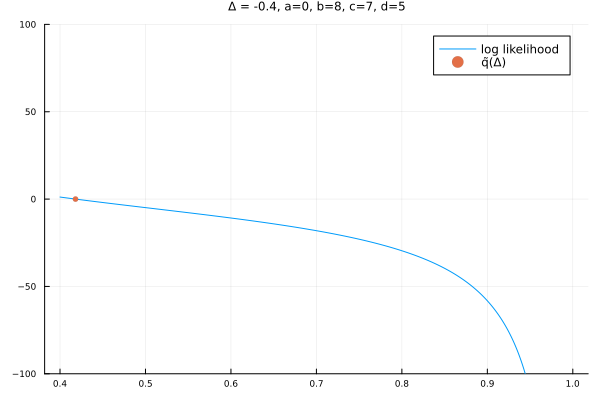

In [12]:
q̃ = qtilde(a, b, c, d; Δ, alg=Order2())
qs = range(max(0, -Δ)+eps(), min(1, 1-Δ)-eps(), 1000)
plot(qs, q -> _f(q, Δ, a, b, c, d); ylim=(-1e2, 1e2), label="log likelihood")
scatter!([q̃], [0.0]; ms=3, msw=0, label="q̃(Δ)")
title!("Δ = $Δ, a=$a, b=$b, c=$c, d=$d")

(a, b, c, d) = (0, 8, 6, 6)
q̃ = qtilde(a, b, c, d; Δ, alg = Order2()) = 0.35418754227416416
q̃ + Δ = -0.045812457725835865
Δ̂ = a / m - c / n = -0.5


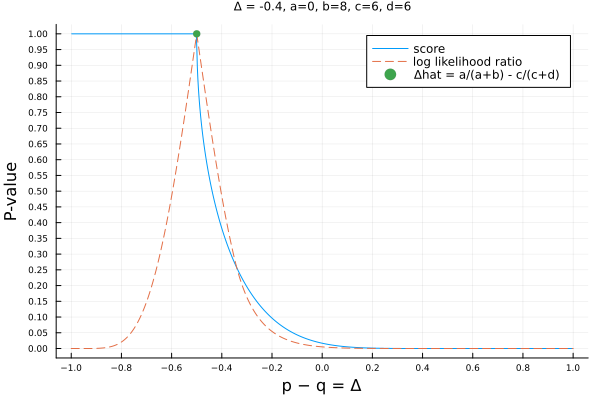

In [13]:
m, n = 8, 12
q, Δ = 0.5, -0.4
(a, b, c, d) = (0, 8, 6, 6)
@show a, b, c, d
@show q̃ = qtilde(a, b, c, d; Δ, alg=Order2())
@show q̃ + Δ
@show Δ̂ = a/m - c/n
Δs = range(-1, 1, 1000)
plot(Δs, Δ -> pvalue_rd_score(a, b, c, d; Δ); label="score")
plot!(Δs, Δ -> pvalue_rd_loglikrat(a, b, c, d; Δ); label="log likelihood ratio", ls=:dash)
plot!(xguide="p − q = Δ", yguide="P-value")
plot!(xtick=-1:0.2:1, ytick=0:0.05:1)
scatter!([Δ̂], [1.0]; ms=4, msw=0, label="Δhat = a/(a+b) - c/(c+d)")
title!("Δ = $Δ, a=$a, b=$b, c=$c, d=$d")

In [14]:
function sim_alphaerrors(m, n, p, q=p; u=1, L=10^5)
    Δ = p - q
    bin1, bin2 = Binomial(m, p), Binomial(n, q)
    pval_loglikrat = similar(zeros(), L)
    pval_zou_donner = similar(zeros(), L)
    Threads.@threads for i in 1:L
        a, c = rand(bin1), rand(bin2)
        b, d = m-a, n-c
        pval_loglikrat[i] = pvalue_rd_loglikrat(a, b, c, d; Δ)
        pval_zou_donner[i] = pvalue_rd_zou_donner(a, b, c, d; Δ, u)
    end
    ecdf_loglikrat = ecdf(pval_loglikrat)
    ecdf_zou_donner = ecdf(pval_zou_donner)
    F_loglikrat(x) = ecdf_loglikrat(x)
    F_zou_donner(x) = ecdf_zou_donner(x)
    (; F_loglikrat, F_zou_donner)
end

function plot_alphaerrors(m, n, p, q=p; u=1, L=10^5, kwargs...)
    (; F_loglikrat, F_zou_donner) = sim_alphaerrors(m, n, p, q; u)
    plot(legend=:bottomright)
    plot!(F_loglikrat, 0, 0.1; label="LLR")
    plot!(F_zou_donner, 0, 0.1; label="ZD", ls=:dash)
    plot!(identity, 0, 0.1; label="", c=:red, ls=:dot, alpha=0.7)
    plot!(xtick=0:0.01:1, ytick=0:0.01:1, xrotation=30)
    title!("Bin(m=$m, p=$p)×Bin(n=$n, q=$q)")
    plot!(size=(400, 400))
    plot!(; kwargs...)
end

function plot_alphaerrors3x3(m, n; u=1, L=10^5, kwargs...)
    for p in 0.1:0.1:0.5
        PP = []
        for q in 0.1:0.1:0.9
            P = plot_alphaerrors(m, n, p, q; u, L, kwargs...)
            push!(PP, P)
        end
        plot(PP...; size=(800, 840), layout=(3, 3))
        plot!(plot_title="m = $m, n = $n, p = $p") |> display
    end
end

plot_alphaerrors3x3 (generic function with 1 method)

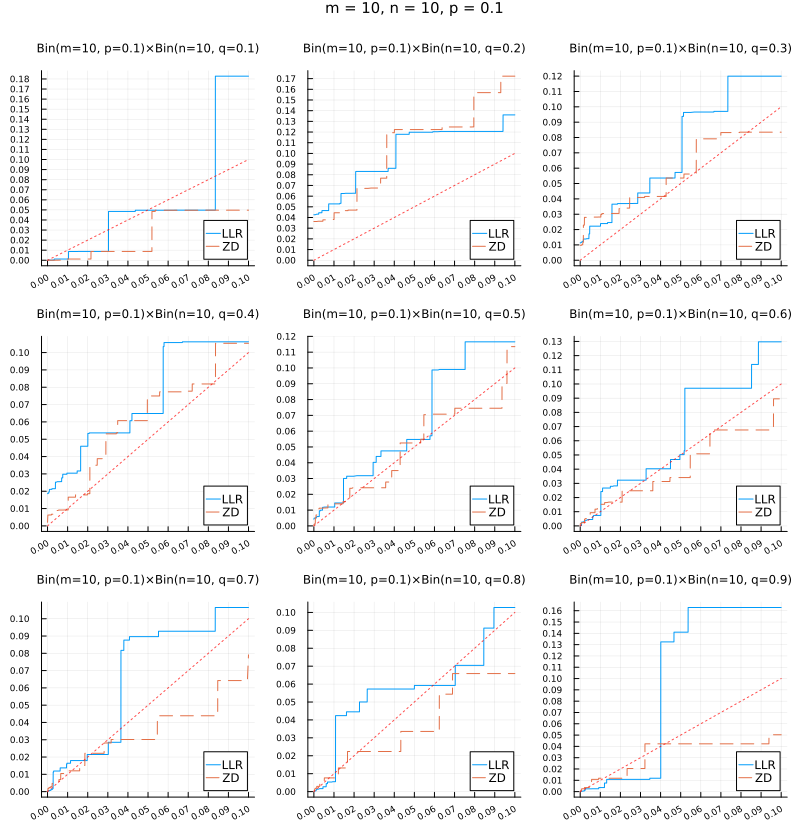

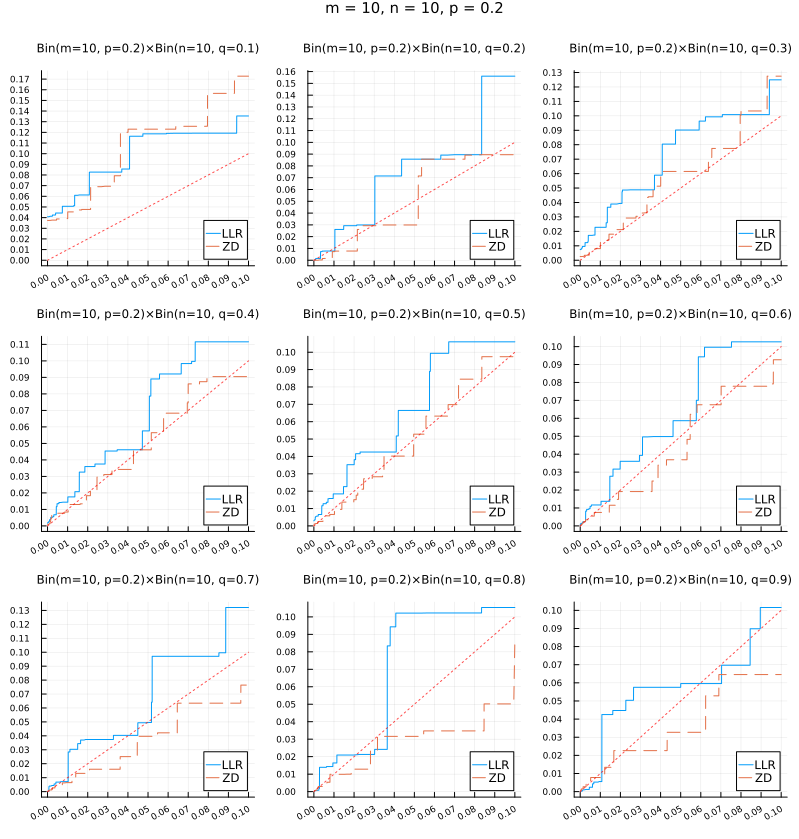

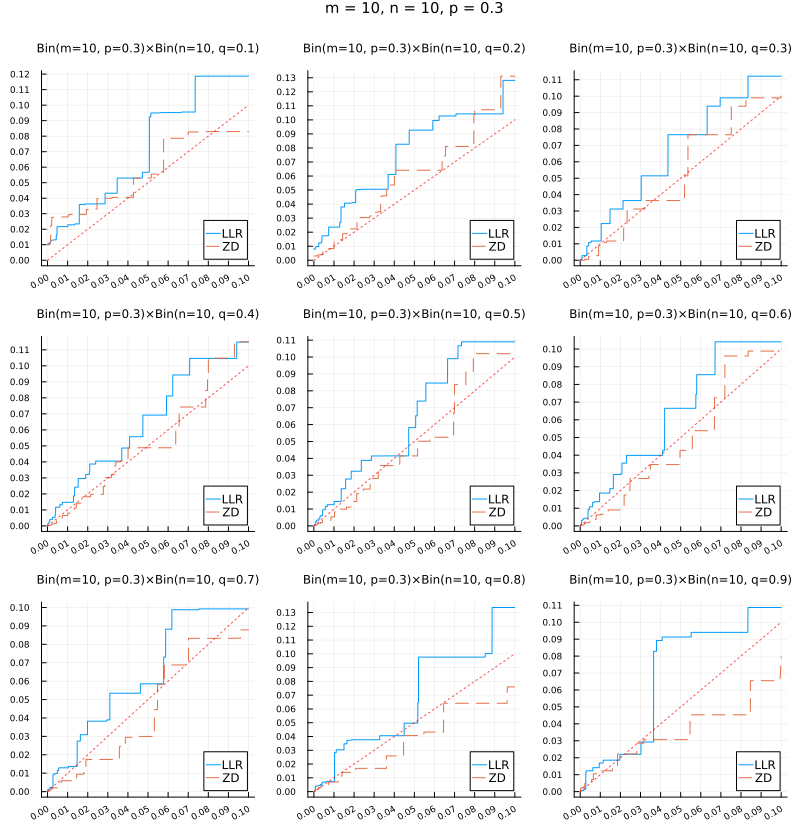

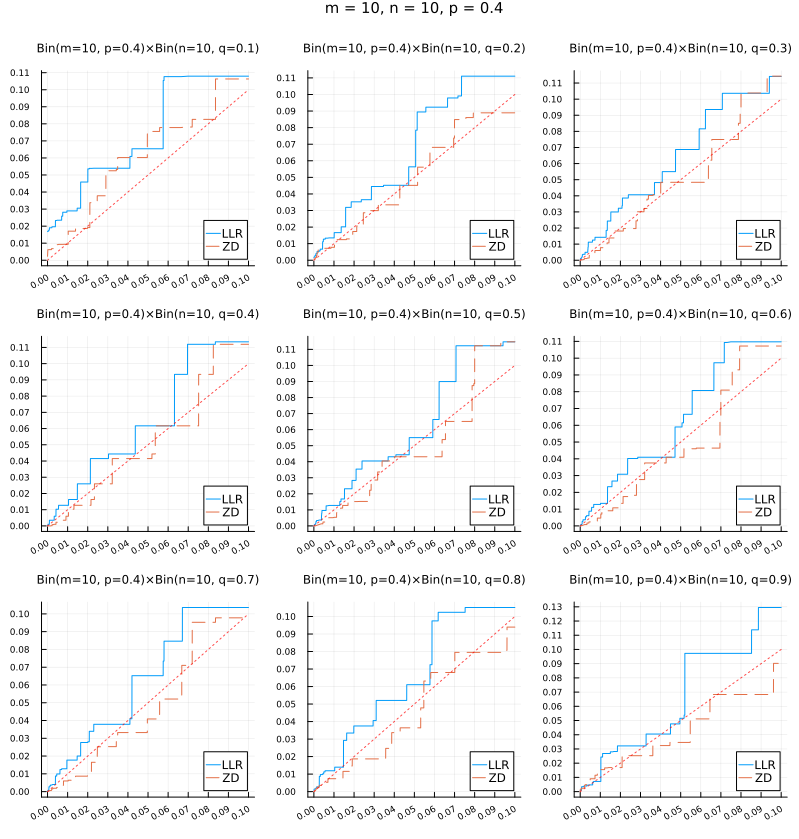

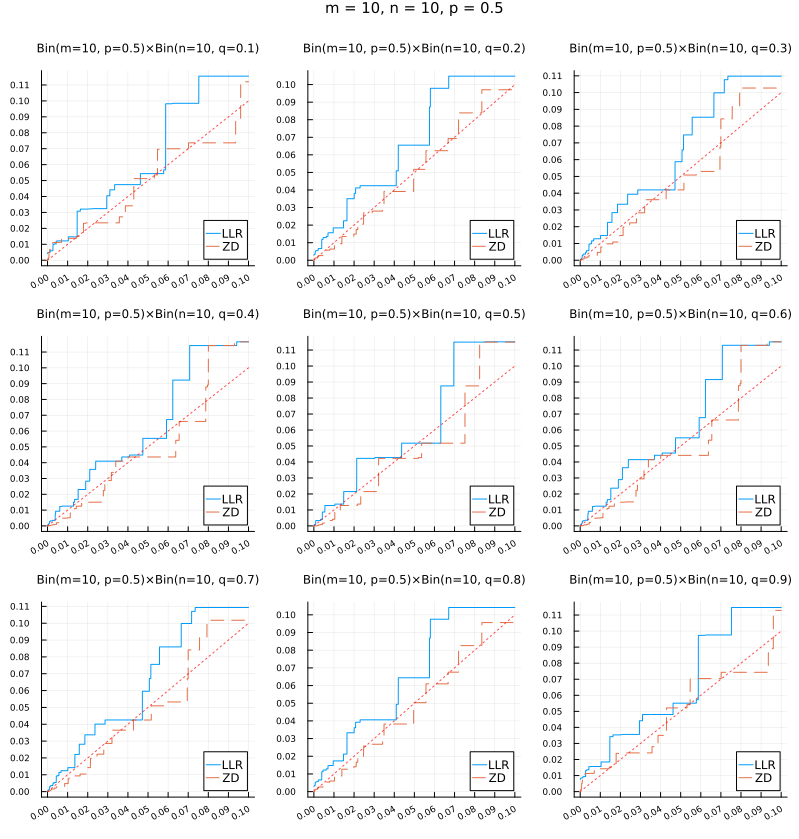

In [15]:
plot_alphaerrors3x3(10, 10; u=0)

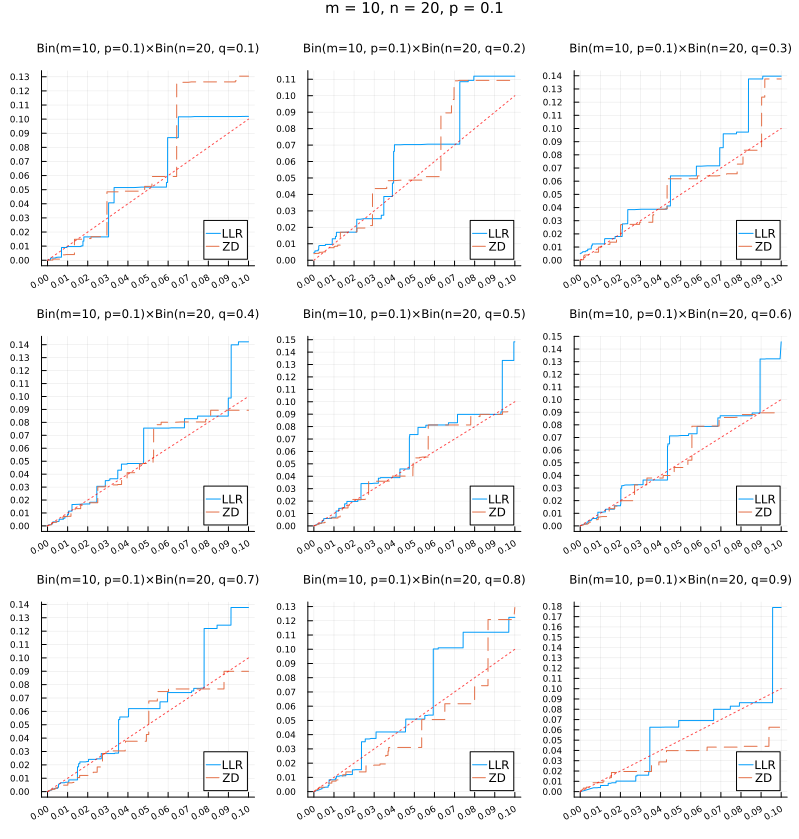

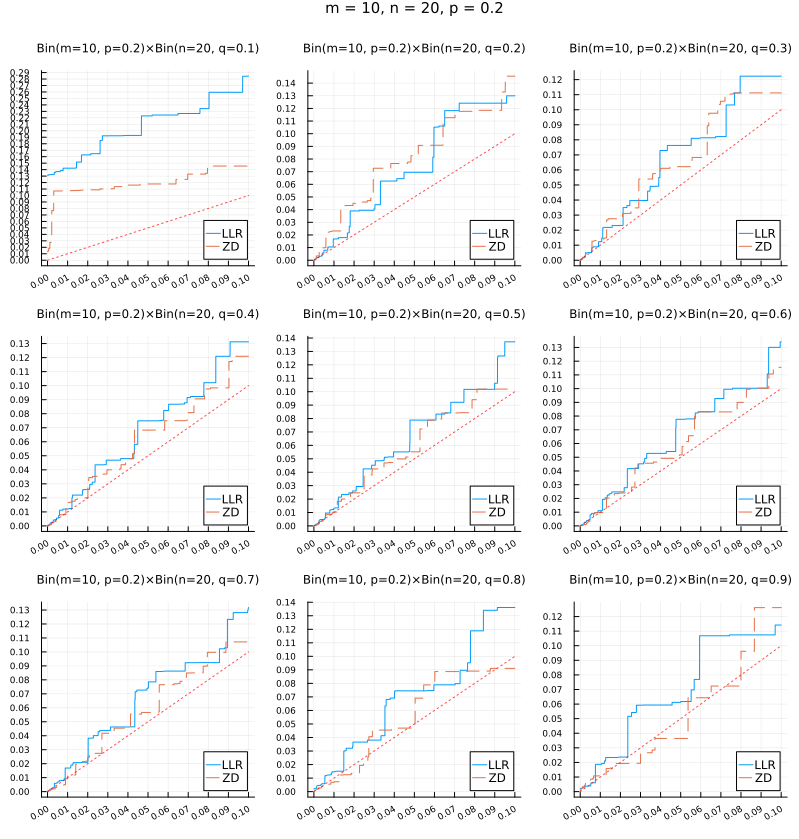

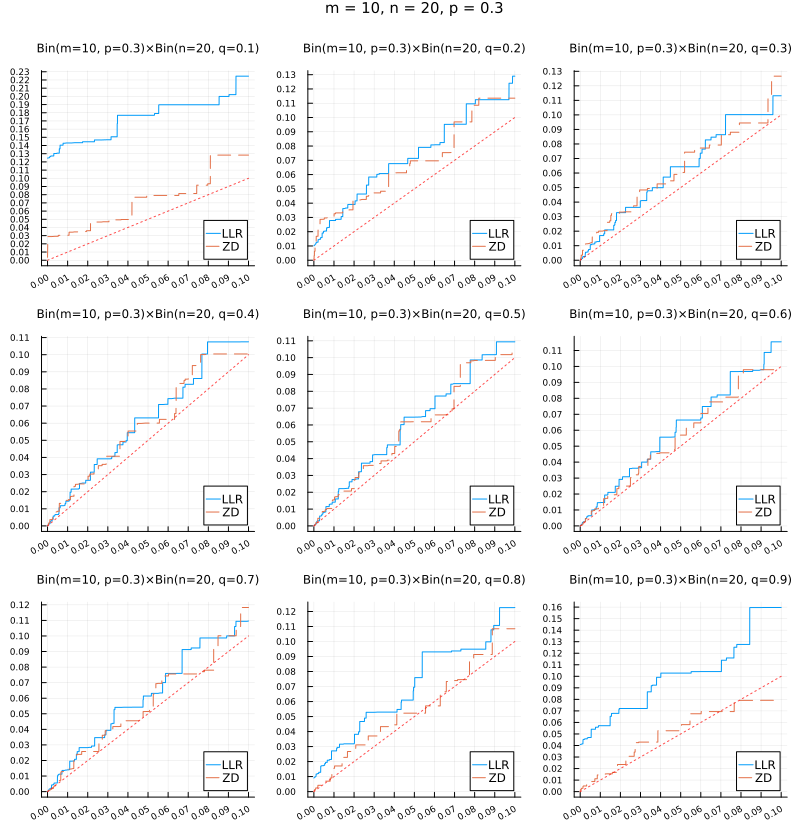

LoadError: TaskFailedException

[91m    nested task error: [39mRoots.ConvergenceFailed("Algorithm failed to converge")
    Stacktrace:
     [1] [0m[1m#find_zero#39[22m
    [90m   @ [39m[90mD:\.julia\packages\Roots\Ez3Om\src\[39m[90m[4mfind_zero.jl:225[24m[39m[90m [inlined][39m
     [2] [0m[1mfind_zero[22m[90m (repeats 2 times)[39m
    [90m   @ [39m[90mD:\.julia\packages\Roots\Ez3Om\src\[39m[90m[4mfind_zero.jl:206[24m[39m[90m [inlined][39m
     [3] [0m[1m#qtilde#9[22m
    [90m   @ [39m[90m.\[39m[90m[4mIn[5]:5[24m[39m[90m [inlined][39m
     [4] [0m[1mchisq_loglikrat[22m[0m[1m([22m[90ma[39m::[0mInt64, [90mb[39m::[0mInt64, [90mc[39m::[0mInt64, [90md[39m::[0mInt64; [90mΔ[39m::[0mFloat64, [90malg[39m::[0mOrder2[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m.\[39m[90m[4mIn[8]:14[24m[39m
     [5] [0m[1m#pvalue_rd_loglikrat#19[22m
    [90m   @ [39m[90m.\[39m[90m[4mIn[10]:7[24m[39m[90m [inlined][39m
     [6] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m.\[39m[90m[4mIn[14]:9[24m[39m[90m [inlined][39m
     [7] [0m[1m(::var"#55#threadsfor_fun#36"{var"#55#threadsfor_fun#35#37"{Int64, Int64, Int64, Vector{Float64}, Vector{Float64}, Binomial{Float64}, Binomial{Float64}, Float64, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m.\[39m[90m[4mthreadingconstructs.jl:84[24m[39m
     [8] [0m[1m#55#threadsfor_fun[22m
    [90m   @ [39m[90m.\[39m[90m[4mthreadingconstructs.jl:51[24m[39m[90m [inlined][39m
     [9] [0m[1m(::Base.Threads.var"#1#2"{var"#55#threadsfor_fun#36"{var"#55#threadsfor_fun#35#37"{Int64, Int64, Int64, Vector{Float64}, Vector{Float64}, Binomial{Float64}, Binomial{Float64}, Float64, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[90mBase.Threads[39m [90m.\[39m[90m[4mthreadingconstructs.jl:30[24m[39m

In [16]:
plot_alphaerrors3x3(10, 20; u=0)

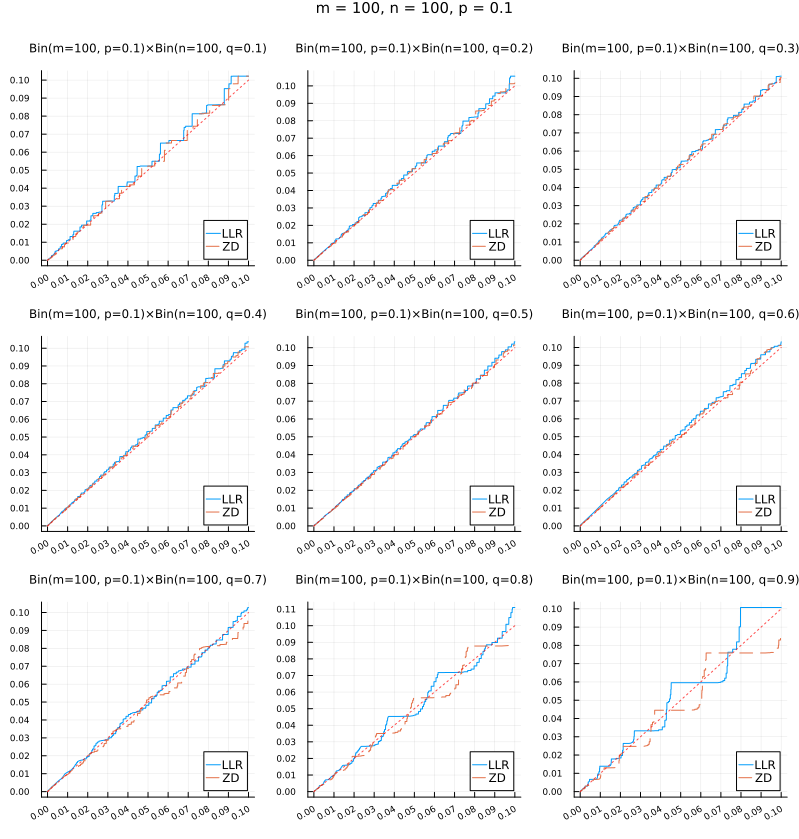

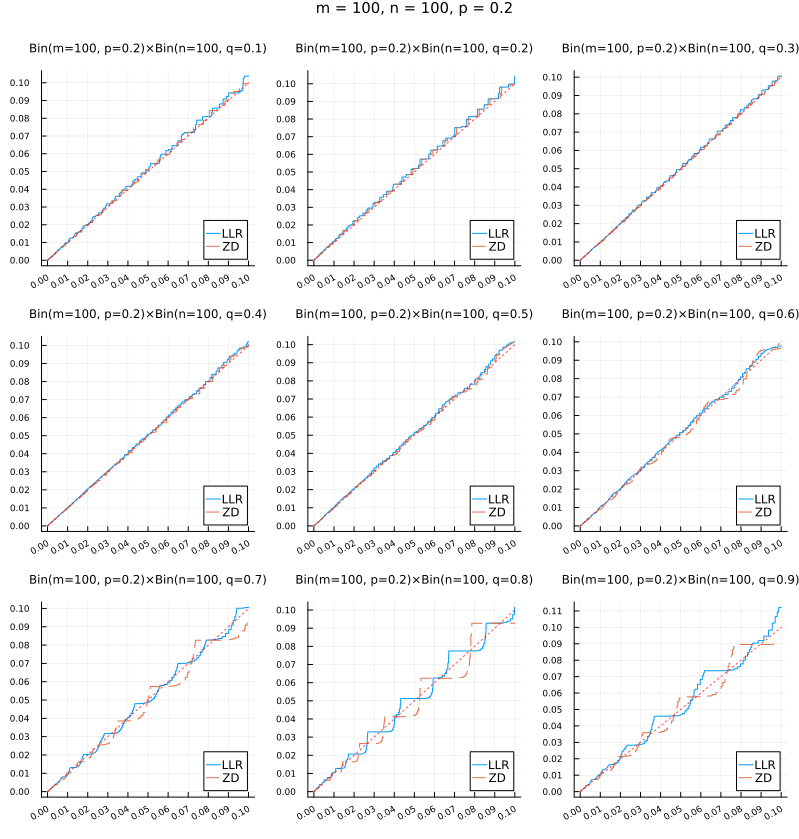

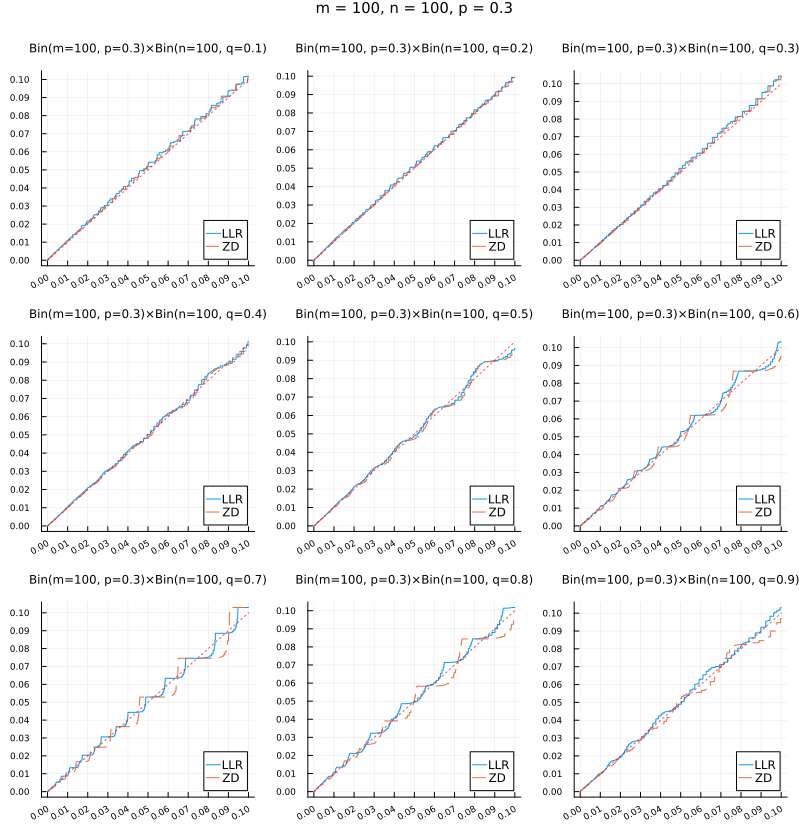

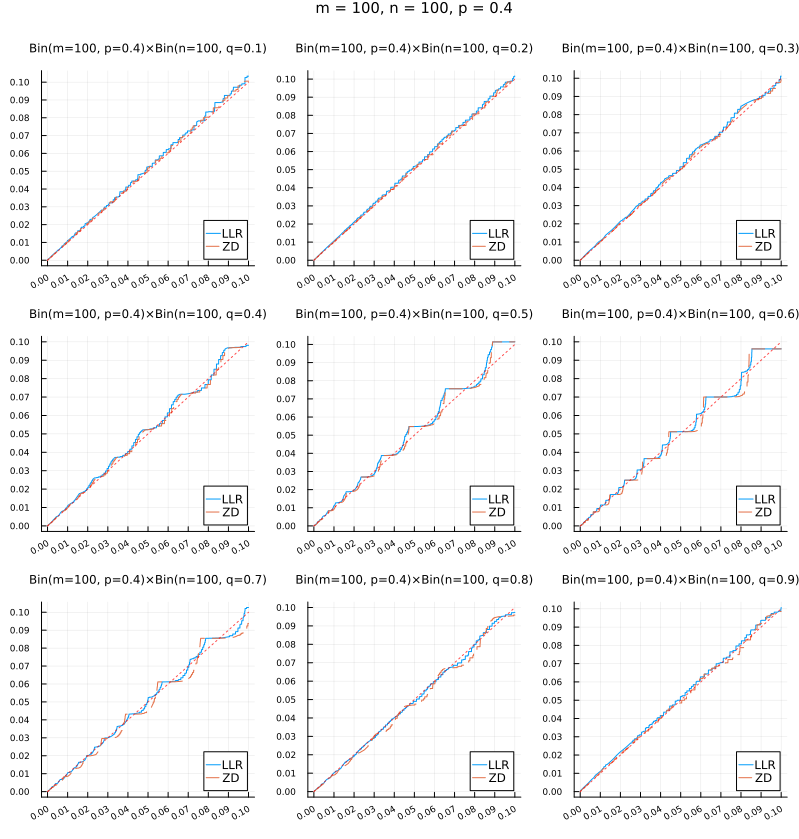

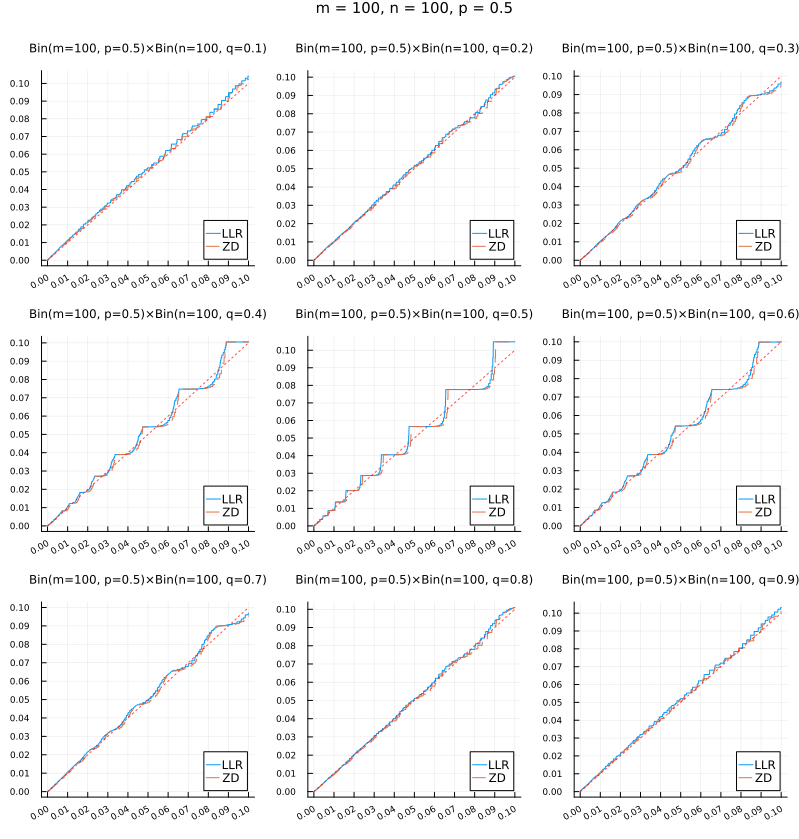

In [17]:
plot_alphaerrors3x3(100, 100; u=0)

結論: Zou-Donnerでよさそう.